In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat,loadmat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())



cuda:2


In [2]:
# def true_1D_1(x): #True function for 1D_1 dy2/dx2 + dy/dx - 6y = 0; BC1: y(0)=2; BC2: dy/dx at (x=0) = -1;
#     y = np.exp(-4.0*x) + np.exp(3.0*x)
#     return y
    

In [3]:
level = "high"
label = "VPol_coPINN_"

#MATLAB Van Der Pol Example https://www.mathworks.com/help/matlab/ref/ode89.html
mu = 1
fo_val = 0.0

loss_thresh = 0.005

x = np.linspace(0,10,100).reshape(-1,1)

bc1_x = x[0].reshape(-1,1)
bc1_y1 = np.array([2]).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y1_bc1_train = torch.from_numpy(bc1_y1).float().to(device)
    

bc1_x = x[0].reshape(-1,1)
bc1_y2 = np.array([fo_val]).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y2_bc1_train = torch.from_numpy(bc1_y2).float().to(device)    


x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)
# y_true = true_1D_1(x_test)
# y_true_norm = np.linalg.norm(y_true,2)

# Domain bounds
lb = np.array(x[0]) 
ub = np.array(x[-1]) 

In [4]:
def colloc_pts(N_f,seed):
    #Collocation Points
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,y)
    x01 = np.array([[0.0, 1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    
    x_coll_train = lb + (ub-lb)*sampling(N_f)
    x_coll_train = np.vstack((x_coll_train, bc1_x.reshape(-1,1))) # append training points to collocation points 

    return x_coll_train

In [6]:
def train_step(x_coll,f_hat):
    
    def closure1():
        optimizer.zero_grad()
        loss = PINN.loss_y1(x_bc1_train,y1_bc1_train,x_coll,f_hat) 
        loss = loss + PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat)
        loss.backward()
        
        return loss
    
#     def closure2():
#         optimizer.zero_grad()
#         loss = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat)
#         loss.backward()
        
#         return loss

    # optimizer.step(closure2)
    optimizer.step(closure1)
    

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(PINN.beta.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_model(max_iter,rep):
    print(rep) 
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    x_coll = torch.from_numpy(colloc_pts(N_f,0)).float().to(device)
    f_hat = torch.zeros(x_coll.shape[0],1).to(device)
    
    loss_np1 = PINN.loss_y1(x_bc1_train,y1_bc1_train,x_coll,f_hat).cpu().detach().numpy()
    loss_np2 = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat).cpu().detach().numpy()
    
    # data_update(loss_np1)
    for i in range(max_iter):
        # x_coll = torch.from_numpy(colloc_pts(N_f,i*11)).float().to(device)
        # f_hat = torch.zeros(x_coll.shape[0],1).to(device)
        train_step(x_coll,f_hat)
        
        loss_np1 = PINN.loss_y1(x_bc1_train,y1_bc1_train,x_coll,f_hat).cpu().detach().numpy()
        loss_np2 = PINN.loss_y2(x_bc1_train,y2_bc1_train,x_coll,f_hat).cpu().detach().numpy()
            
        # data_update(loss_np1)
        # print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        print(i,"Loss1",loss_np1,"Loss2",loss_np2)
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
from vanPol_model import Sequentialmodel_coPINN

max_reps = 1
max_iter = 200

N_f = 1000

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss =[]
    beta_val = []
    
    'Generate Training data'
    torch.manual_seed(reps*36)
     #Total number of collocation points 
    
    
    layers = np.array([1,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    # layers = np.array([1,50,50,50,50,1])
    PINN = Sequentialmodel(layers)
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25, 
                              max_iter = 10, 
                              max_eval = 15, 
                              tolerance_grad = 1e-5, 
                              tolerance_change = 1e-5, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
   

    train_model(max_iter,reps)

    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)    
    
    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full, "test_re_loss": test_re_full, "Time": elapsed_time, "beta": beta_full, "label": label, "Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-8): 8 x Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-8): 8 x Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Loss1 0.060991816 Loss2 0.29988474
1 Loss1 0.14229538 Loss2 0.12897347
2 Loss1 0.07043267 Loss2 0.15698047
3 Loss1 0.0434107 Loss2 0.16174334
4 Loss1 0.062165856 Loss2 0.13828078
5 Loss1 0.058636367 Loss2 0.13620228
6 Loss1 0.061222132 Loss2 0.12854761
7 Loss1 0.07095095 Loss2 0.115674235
8 Loss1 0.079131566 Loss2 0.104732305
9 Loss1 0.07734981 Loss2 0.10191389
10 Loss1 0.08182653 Loss2 0.09581991
11 Loss1 0.09430945 Loss2 0.08038281
12 Loss1 0.09631384 Loss2 0.07639059
13 Loss1 0.09534701 Lo

In [10]:
u_pred = PINN.test()
# plt.plot(x,u_pred,'r')
# plt.plot(y_true,'b')

In [20]:
PINN.state_dict().keys()

odict_keys(['beta1', 'beta2', 'linears1.0.weight', 'linears1.0.bias', 'linears1.1.weight', 'linears1.1.bias', 'linears1.2.weight', 'linears1.2.bias', 'linears1.3.weight', 'linears1.3.bias', 'linears1.4.weight', 'linears1.4.bias', 'linears1.5.weight', 'linears1.5.bias', 'linears1.6.weight', 'linears1.6.bias', 'linears1.7.weight', 'linears1.7.bias', 'linears1.8.weight', 'linears1.8.bias', 'linears1.9.weight', 'linears1.9.bias', 'linears2.0.weight', 'linears2.0.bias', 'linears2.1.weight', 'linears2.1.bias', 'linears2.2.weight', 'linears2.2.bias', 'linears2.3.weight', 'linears2.3.bias', 'linears2.4.weight', 'linears2.4.bias', 'linears2.5.weight', 'linears2.5.bias', 'linears2.6.weight', 'linears2.6.bias', 'linears2.7.weight', 'linears2.7.bias', 'linears2.8.weight', 'linears2.8.bias', 'linears2.9.weight', 'linears2.9.bias'])

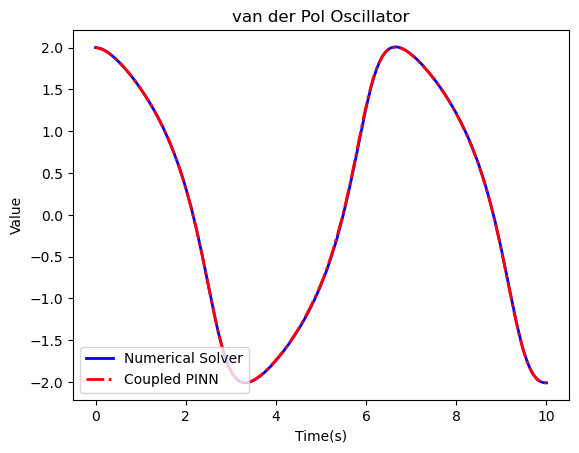

In [23]:
data_mat = loadmat('Vanderpol_ODEsolver.mat')
y = data_mat['y'][:,0]
t = data_mat['t']

fig,ax = plt.subplots()
ax.plot(t,y,'b',linewidth = 2,label = 'Numerical Solver')
ax.plot(x,u_pred,'r-.',linewidth = 2,label = 'Coupled PINN')
ax.set_xlabel('Time(s)')
ax.set_ylabel('Value')
ax.set_title('van der Pol Oscillator')
ax.legend(loc = 3)
# plt.savefig('Coupled_PINN_VanderPol.svg',format = 'svg')
# plt.savefig('Coupled_PINN_VanderPol.png',format = 'png')

In [1]:
u_pred

NameError: name 'u_pred' is not defined

In [13]:
x

array([[ 0.        ],
       [ 0.1010101 ],
       [ 0.2020202 ],
       [ 0.3030303 ],
       [ 0.4040404 ],
       [ 0.50505051],
       [ 0.60606061],
       [ 0.70707071],
       [ 0.80808081],
       [ 0.90909091],
       [ 1.01010101],
       [ 1.11111111],
       [ 1.21212121],
       [ 1.31313131],
       [ 1.41414141],
       [ 1.51515152],
       [ 1.61616162],
       [ 1.71717172],
       [ 1.81818182],
       [ 1.91919192],
       [ 2.02020202],
       [ 2.12121212],
       [ 2.22222222],
       [ 2.32323232],
       [ 2.42424242],
       [ 2.52525253],
       [ 2.62626263],
       [ 2.72727273],
       [ 2.82828283],
       [ 2.92929293],
       [ 3.03030303],
       [ 3.13131313],
       [ 3.23232323],
       [ 3.33333333],
       [ 3.43434343],
       [ 3.53535354],
       [ 3.63636364],
       [ 3.73737374],
       [ 3.83838384],
       [ 3.93939394],
       [ 4.04040404],
       [ 4.14141414],
       [ 4.24242424],
       [ 4.34343434],
       [ 4.44444444],
       [ 4

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(PINN)

42002